In [1]:
import sys
from pathlib import Path
import os

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import wandb

api = wandb.Api()
sweep = api.sweep("23f2001173-indian-institute-of-technology-madras/garbage_clf-src_scripts/9vh2qqg0")

best_run = sweep.best_run()
print(f"Best run: {best_run.name}")
print(f"Best val_accuracy: {best_run.summary.get('val_accuracy')}")

for key, value in best_run.config.items():
    if not key.startswith('_'):
        print(f"  {key}: {value}")

wandb: Sorting runs by -summary_metrics.val_accuracy


Best run: wild-sweep-6
Best val_accuracy: 0.9817073345184326
  lr: 0.00039783231707870914
  data_dir: data
  img_size: 224
  batch_size: 64
  max_epochs: 10
  num_classes: 6
  num_workers: 4
  freeze_strategy: finetune_all
  backbone_lr_factor: 0.1
  use_differential_lr: False


In [3]:
_config = best_run.config
class Config:
    def __init__(self, cfg):
        for k, v in cfg.items():
            setattr(self, k, v)
config = Config(_config)

In [13]:
import glob

best_acc = best_run.summary.get('val_accuracy')
best_acc_str = f"{best_acc:.4f}"

ckpt_pattern = f"{PROJECT_ROOT}/checkpoints/ft_best_model_*val_accuracy={best_acc_str}.ckpt"
ckpts = glob.glob(ckpt_pattern)

checkpoint_path = ckpts[0]
print(f"Found checkpoint: {checkpoint_path}")

Found checkpoint: /home/nevrohelios/project/garbage_clf/checkpoints/ft_best_model_epoch=08_val_accuracy=0.9817.ckpt


In [5]:
import pytorch_lightning as pl
from src.models.pretrained import get_pretrained_model
from src.lightning.model import ModelLightning
from src.data.module import DataLoaderWrapper

dm = DataLoaderWrapper(
    data_dir=PROJECT_ROOT / config.data_dir,
    img_size=config.img_size,
    mode="augment",
    batch_size=config.batch_size,
    num_workers=config.num_workers,
)

freeze_strategy = config.freeze_strategy
freeze_layers = 0
if freeze_strategy == 'freeze_backbone_half':
    temp_model = get_pretrained_model(config.num_classes, 'finetune_all')
    num_blocks = len(list(temp_model.features.children()))
    freeze_layers = int(num_blocks * 0.5)
    freeze_strategy = 'freeze_k_layers'
    del temp_model

model = get_pretrained_model(
    num_classes=config.num_classes,
    freeze_strategy=freeze_strategy,
    freeze_layers=freeze_layers
)

backbone_lr = None
head_params = None
if getattr(config, 'use_differential_lr', False):
    backbone_lr = config.lr * config.backbone_lr_factor
    head_params = list(model.classifier.parameters())

pl_model = ModelLightning.load_from_checkpoint(
    checkpoint_path,
    model=model,
    idx_to_class=dm.idx_to_class,
    backbone_lr=backbone_lr,
    head_params=head_params,
    strict=False
)

/home/nevrohelios/miniconda3/envs/flsplit/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
trainer = pl.Trainer(
    accelerator='auto',
    devices='auto'
)

preds = trainer.test(pl_model, datamodule=dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_accuracy          │       0.9840637445449829       │
│    test_f1_class_cardboard     │              1.0               │
│      test_f1_class_glass       │       0.9897959232330322       │
│      test_f1_class_metal       │       0.9811320900917053       │
│      test_f1_class_paper       │       0.9917355179786682       │
│     test_f1_class_plastic      │       0.9793814420700073       │
│      test_f1_class_trash       │       0.9056603908538818       │
│           test_loss            │      0.07531262934207916       │
│ test_precision_class_cardboard │              1.0               │
│   test_precision_class_glass   │       0.9797979593276978       │
│   test_precision_class_metal   │       0.9873417615890503       │
│   test_precision_class_paper   │       0.9836065769195557       │
│  test_precision_class_plastic  │       0.9693877696990967       │
│   test_precision_class_trash   │              1.0               │
│  test_recall_class_cardboard   │              1.0               │
│    test_recall_class_glass     │              1.0               │
│    test_recall_class_metal     │       0.9750000238418579       │
│    test_recall_class_paper     │              1.0               │
│   test_recall_class_plastic    │       0.9895833134651184       │
│    test_recall_class_trash     │       0.8275862336158752       │
└────────────────────────────────┴────────────────────────────────┘

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.1975338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1760424..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.378562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9809059.

<Figure size 2200x1000 with 0 Axes>

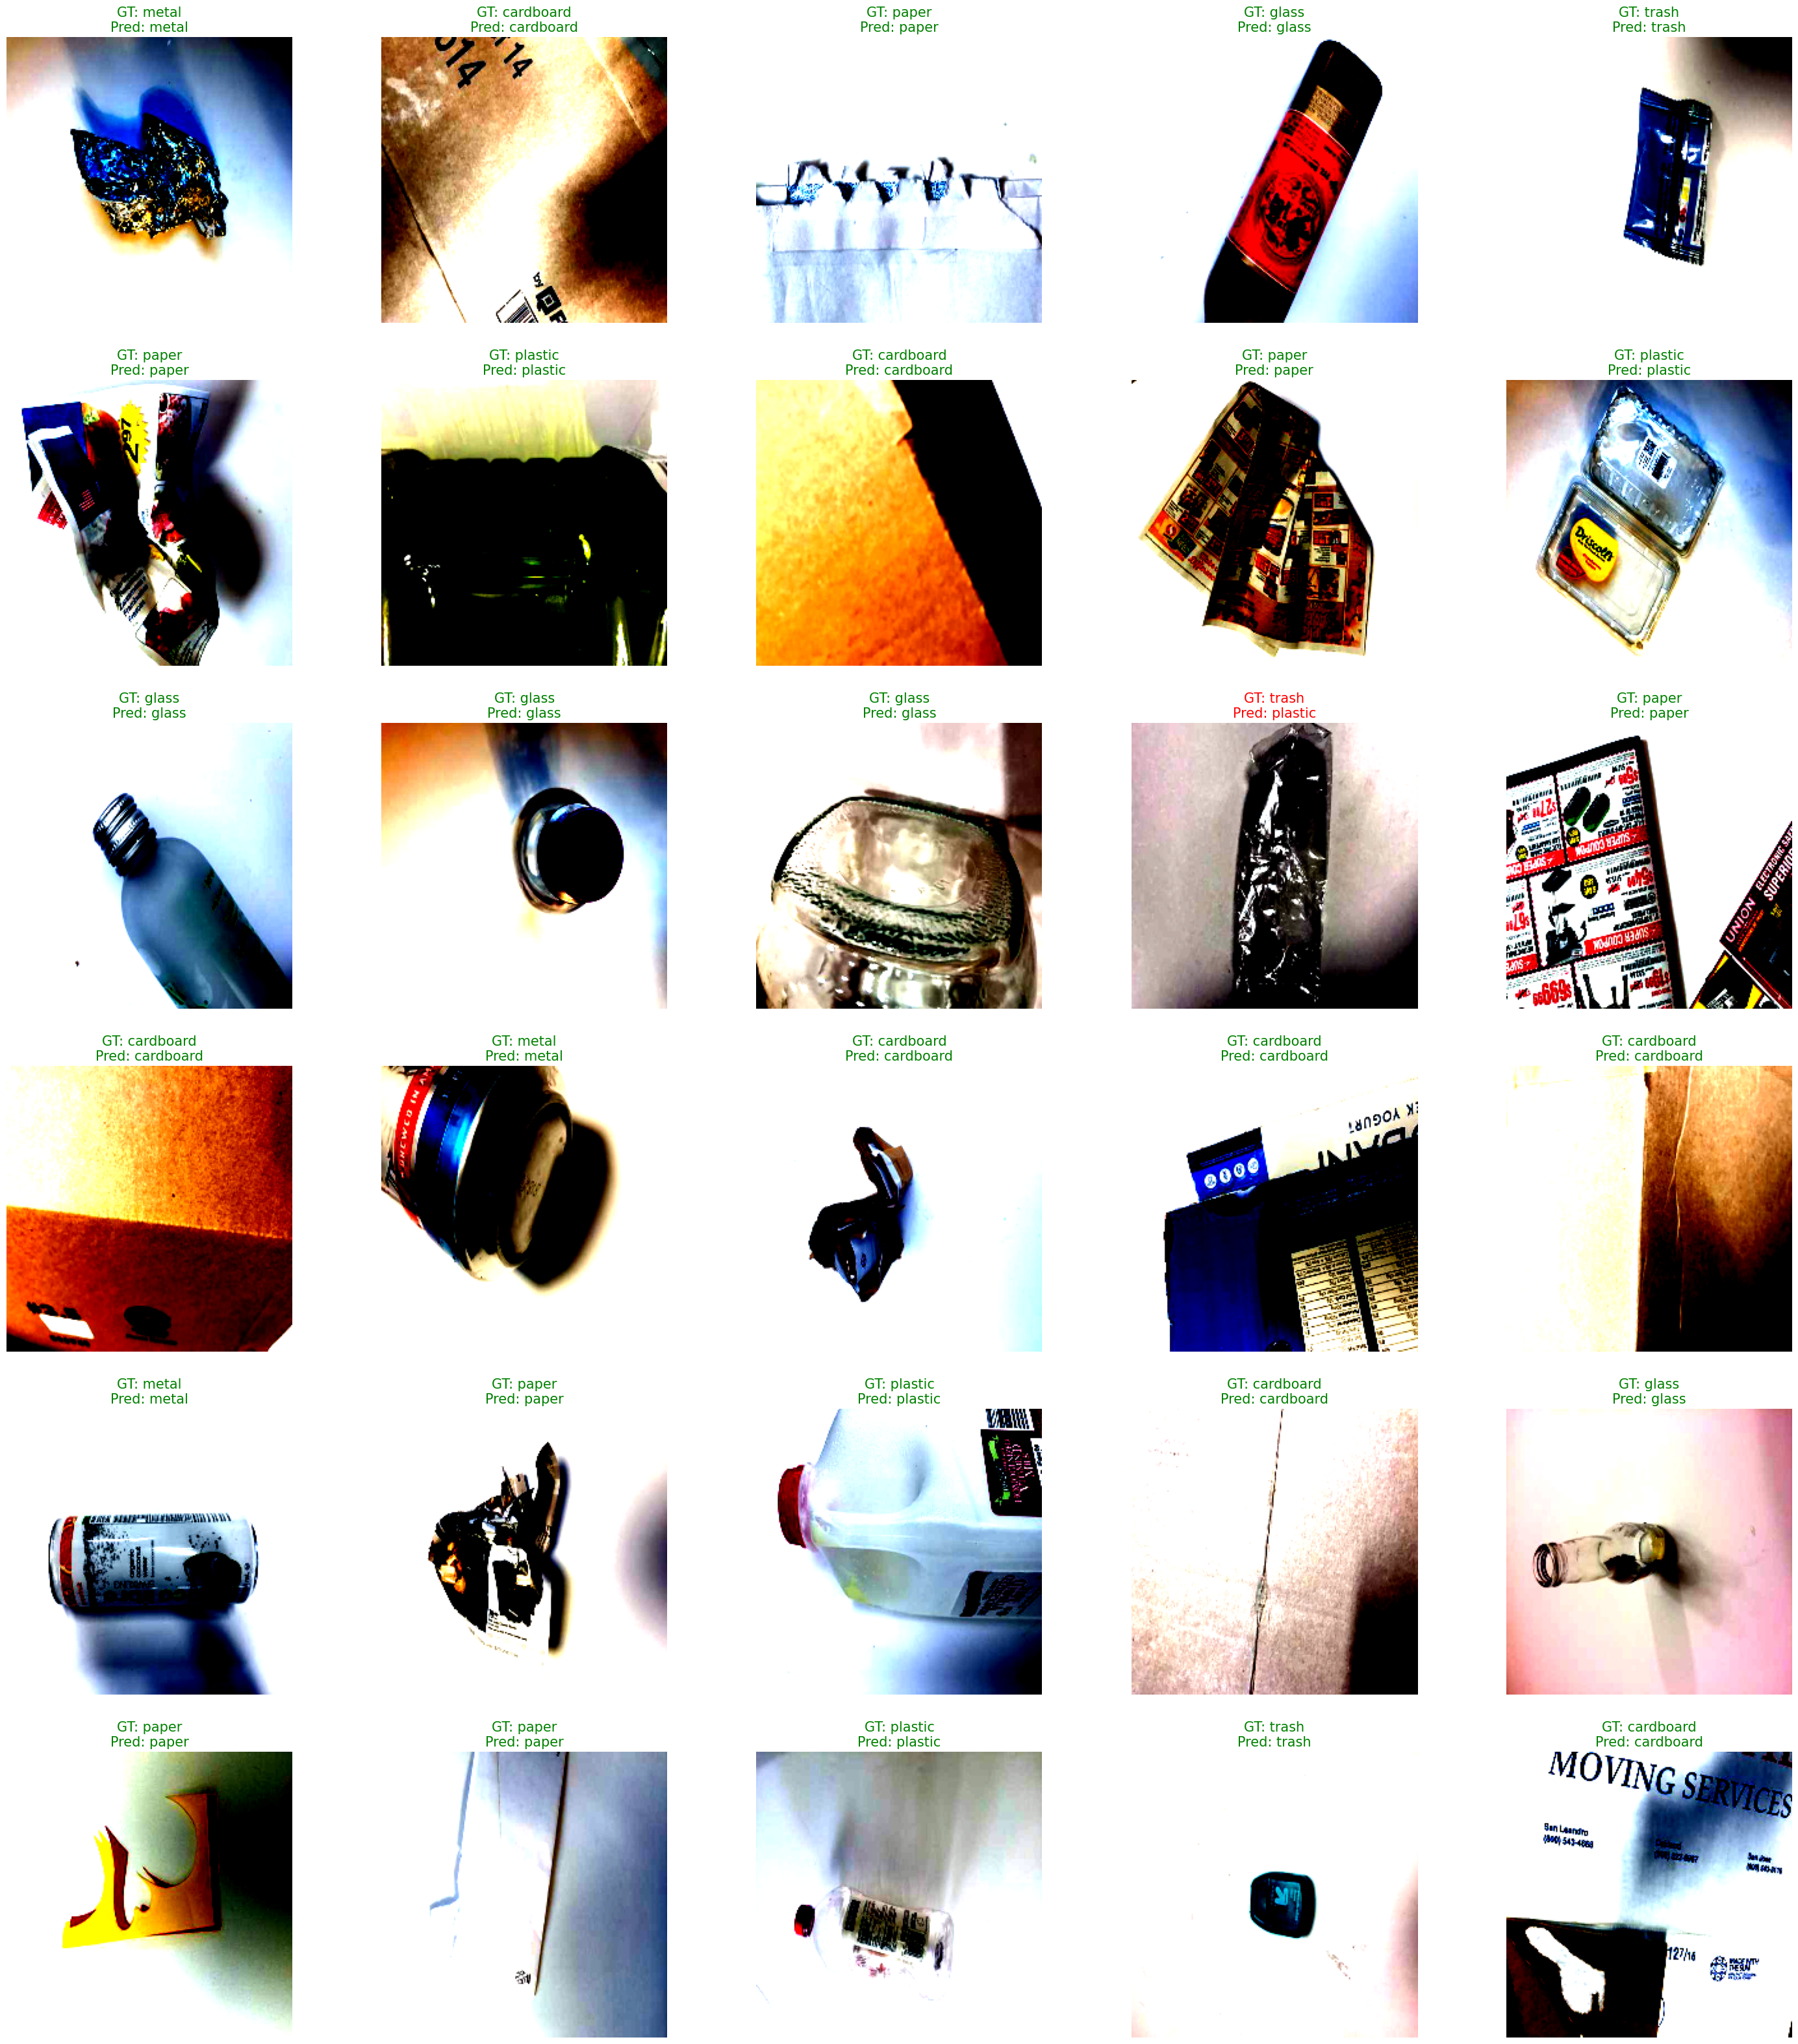

In [12]:
import random
import torch
import matplotlib.pyplot as plt

test_dataset = dm.val_dataloader()
d = test_dataset.dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pl_model.to(device)

sample_idxs = random.sample(range(len(d)), 30)
samples = torch.stack([d[i][0] for i in sample_idxs])
labels = torch.tensor([d[i][1] for i in sample_idxs])
outputs = pl_model.forward(samples.to(device))
preds = torch.argmax(outputs, 1).cpu()

plt.figure(figsize=(22, 10))
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(36, 40))
axs = axs.ravel()

for i, ax in enumerate(axs):
    img = samples[i].cpu()

    # CHW → HWC
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0)

    img = img.numpy()

    ax.imshow(img,)
    ax.axis("off")

    gt = dm.idx_to_class[labels[i].item()]
    pred = dm.idx_to_class[preds[i].item()]

    color = "green" if gt == pred else "red"

    ax.set_title(
        f"GT: {gt}\nPred: {pred}",
        fontsize=15,
        color=color
    )

# plt.tight_layout()
plt.show()